In [1]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import datasets.dataset_factory as d_f
import models.model_factory as m_f
import losses.loss_factory as l_f
import tb_visualization.tensorboard_factory as tb_f
import saver.saver_factory as s_f
import configs.config_factory as c_f

In [2]:
project_root = '/home/ishan/Bisenetv1'
type_dataset = 'CelebAMask_HQ'    # CelebAMask_HQ | FaceSynthetic
type_model = 'bisenetv1'
type_task = 'segmentation'
type_loss = 'OhemCELoss'
type_scheduler = 'ExponentialLR'
type_saver = 'standard_seg'
load_from_snapshot = True
tb_name = '28082023_terminal_test_v6'
cfg_dict = dict(
    type_model=type_model,
    type_dataset=type_dataset,
)
cfg=c_f.config_factory(cfg_dict)

# training_dict = dict(
#     num_epochs=1,
#     learning_rate=5e-3,   
#     weight_decay=1e-4,
#     n_img_per_gpu=2,
#     eval_ims_per_gpu=1,
#     print_gap_batches=100,
#     save_every=5000,
#     loss_thresh=0.7,
#     cropsize = [448, 448],
#     ignore_lb = -100,
# )

dataset_dict = dict(
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

general_dict = dict(
    type_dataset=type_dataset,
    type_model=type_model,
    type_task=type_task,
    type_loss=type_loss,
    type_scheduler=type_scheduler,
    type_vis=type_task,
    type_saver=type_saver,
    cfg=cfg,
    training_dict=cfg['training_dict'],
    dataset_dict=dataset_dict,
    device=torch.device("cuda"),
    project_root=project_root,
    snapshot_path=f'{project_root}/res/snapshots/snapshot.pt',
    model_path=f'{project_root}/res/terminal_test',
    tb_path=f'{project_root}/runs',
    tb_name=tb_name
)

In [3]:
general_dict['cfg']["gamma_scheduler"]

0.95

In [4]:
def training_loop(
    dataloaders:list(),
    network:nn.Module, 
    criterion, 
    optimizer, 
    scheduler, 
    training_dict:dict(), 
    vis=None, 
    saver=None
    ) -> nn.Module:

    #Training mode:
    network.train()

    for epoch in range(training_dict["num_epochs"]):

        #Start counting time:
        start = time.perf_counter()

        #Printing the epoch:
        print("Epoch {}/{}".format(epoch + 1, training_dict["num_epochs"]))

        for idx_batch, data_dict in enumerate(dataloaders):
            torch.cuda.empty_cache()
            #Set gradients to zero:
            optimizer.zero_grad()

            # Compute prediction:
            pred_dict = network(data_dict=data_dict)

            # Compute loss:
            loss = criterion.compute_loss(pred_dict=pred_dict)

            # Backpropagation:
            criterion.backward(loss)

            # Update the parameters:
            optimizer.step()

            # #Updating the tensorboard:
            if (vis is not None) and (idx_batch % training_dict['print_gap_batches'] == 0):
                if idx_batch == 0:
                    print(f'Batch {idx_batch}')
                    start_time = time.time()
                else:
                    end_time = time.time()
                    dur = end_time - start_time
                    print(f'Batch {idx_batch} | Duration:{dur:.2f}s')
                    start_time = time.time()

                #Calculating the iteration:
                iteration = epoch * len(dataloaders) + idx_batch

                # #Creating dict for the tensorboard:
                info_dict = {
                    'pred': pred_dict,
                    'loss': loss,
                    'data_dict': data_dict,
                    'epoch': epoch,
                    'lr': scheduler.get_last_lr()[0],
                    'iteration': iteration
                    }

                #Updating the tensorboard:
                vis.update(info_dict=info_dict)
                breakpoint
        
        ################################################################################
        #Saving the model:
        if saver is not None:
            saver.save(model=network, optimizer=optimizer, crrnt_loss=loss, epoch=epoch)
        ################################################################################

        #Update the scheduler:
        scheduler.step()

        #Stop counting time and printing it:
        time_epoch = time.strftime("%H:%M:%S", time.gmtime(time.perf_counter() - start))
        print(f'Time per epoch: {time_epoch}')
        print("-" * 10, flush=True)
        print()
        # state = network.module.state_dict() if hasattr(network, 'module') else network.state_dict()
        # torch.save(state, save_pth)
    #Return the model:
    return network

In [5]:
# def train_run(general_dict):

#Getting dataset:
dataset, info_dataset_dict = d_f.dataset_factory(
    type_dataset=general_dict['type_dataset'], 
    conf=general_dict
    )


In [6]:

#Creating dataloader:
dataloader = DataLoader(
    dataset, 
    batch_size=general_dict['dataset_dict']["batch_size"], 
    shuffle=general_dict['dataset_dict']["shuffle"], 
    num_workers=general_dict['dataset_dict']["num_workers"],
    pin_memory=general_dict['dataset_dict']["pin_memory"]
    )
print('Number of images to train:', len(dataloader.dataset))


Number of images to train: 30000


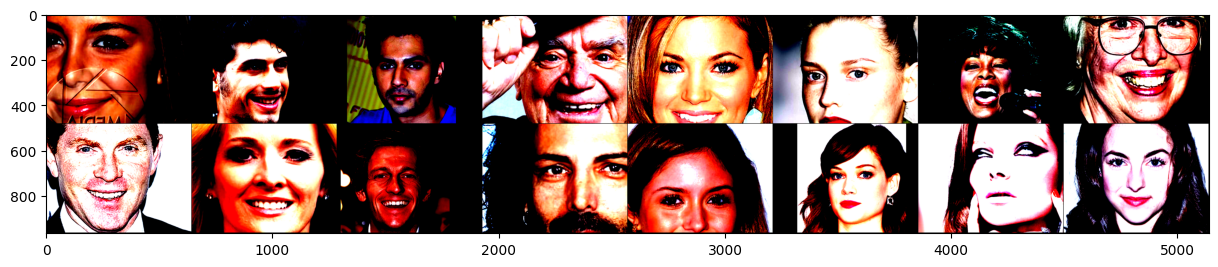

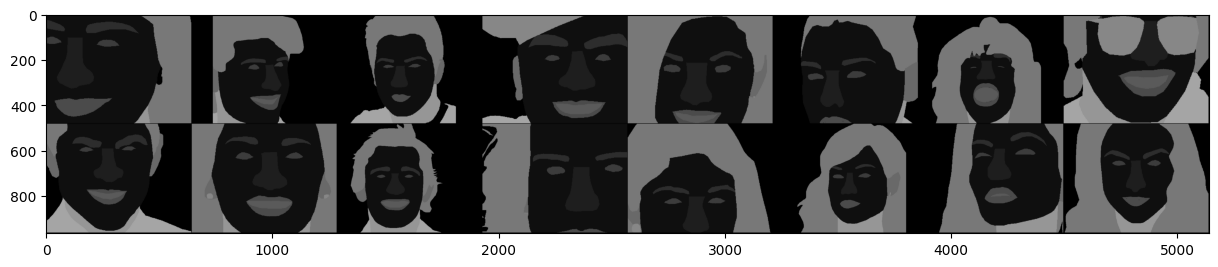

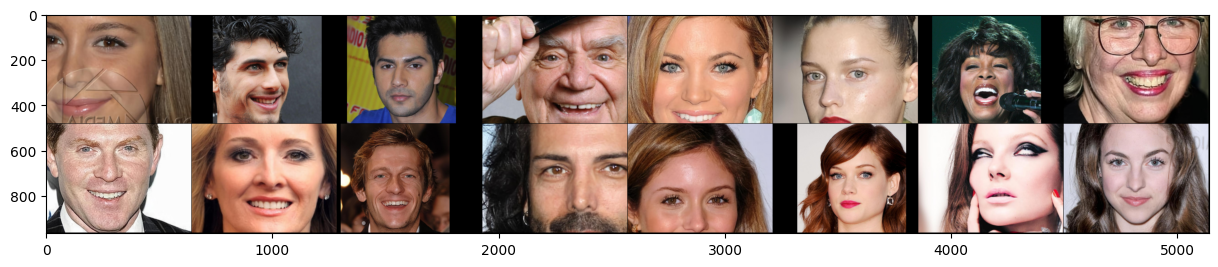

In [7]:
################################################################################
batch = next(iter(dataloader))

images, labels, og= batch['img'], batch['label'], batch['og_img']
grid_img = torchvision.utils.make_grid(images, nrow=8)

plt.figure(figsize=(15,15))
plt.imshow(np.clip(np.transpose(grid_img, (1,2,0)),0,1))

grid_lb = torchvision.utils.make_grid(labels, nrow=8)

plt.figure(figsize=(15,15))
plt.imshow((np.transpose(grid_lb, (1,2,0)))*15)

grid_og_img = torchvision.utils.make_grid(og, nrow=8)

plt.figure(figsize=(15,15))
plt.imshow(np.clip(np.transpose(grid_og_img, (1,2,0)),0,1))
################################################################################

In [8]:

# Model:
network_object = m_f.model_factory(
    type_model=general_dict['type_model'], 
    conf=general_dict
    )
network_object.to(general_dict['device'])


BiSeNet(
  (cp): ContextPath(
    (resnet): Resnet18(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [9]:
# Criterion:
loss_object = l_f.loss_factory(
    type_loss=general_dict['type_loss'], 
    conf=general_dict
    )

In [10]:
# Optimizer:
optimizer = torch.optim.Adam(
    params=network_object.parameters(), 
    lr=general_dict['training_dict']["learning_rate"]
    )

In [11]:
# Scheduler:
opt_lr_scheduler = lr_scheduler.ExponentialLR(
    optimizer=optimizer, 
    gamma=general_dict['cfg']["gamma_scheduler"]
    )

In [12]:
# Tensorboard:
vis_object = tb_f.tensorboard_factory(
    type_vis=general_dict['type_vis'], 
    conf=general_dict
    )


In [13]:

# Saver of the model:
saver_object = s_f.save_factory(
    type_saver=general_dict['type_saver'], 
    conf=[general_dict, info_dataset_dict]
    )


In [14]:
# Start counting training time:
start_time = time.perf_counter()
print("Start training!")

Start training!


In [15]:
#Training loop:
model = training_loop(
    dataloaders=dataloader, 
    network=network_object,
    criterion=loss_object, 
    optimizer=optimizer, 
    scheduler=opt_lr_scheduler,
    vis=vis_object, 
    training_dict=general_dict['training_dict'], 
    saver=saver_object
    )

#Finish counting training time:
total_time = time.strftime("%H:%M:%S", time.gmtime(time.perf_counter() - start_time))
print(f'Total training time: {total_time}')
print("Done!")

Epoch 1/2
Batch 0
Batch 100 | Duration:61.97s
Batch 200 | Duration:61.90s
Batch 300 | Duration:61.58s
Batch 400 | Duration:61.69s
Batch 500 | Duration:61.31s
Batch 600 | Duration:58.59s
Batch 700 | Duration:61.12s
Batch 800 | Duration:61.04s
Batch 900 | Duration:61.45s
Batch 1000 | Duration:61.79s
Batch 1100 | Duration:55.48s
Batch 1200 | Duration:61.16s
Batch 1300 | Duration:61.04s
Batch 1400 | Duration:59.87s
Batch 1500 | Duration:60.96s
Batch 1600 | Duration:61.14s
Batch 1700 | Duration:59.74s
Batch 1800 | Duration:61.06s
Model checkpoint saved at epoch: 0
Time per epoch: 00:19:06
----------

Epoch 2/2
Batch 0
Batch 100 | Duration:61.13s
Batch 200 | Duration:59.96s
Batch 300 | Duration:61.11s
Batch 400 | Duration:61.22s
Batch 500 | Duration:59.51s
Batch 600 | Duration:61.13s
Batch 700 | Duration:61.10s
Batch 800 | Duration:59.78s
Batch 900 | Duration:61.12s
Batch 1000 | Duration:61.33s
Batch 1100 | Duration:59.88s
Batch 1200 | Duration:60.97s
Batch 1300 | Duration:61.26s
Batch 1400 

In [17]:
respth = '/home/ishan/Bisenetv1/res/terminal_test'
save_pth = os.path.join(respth, f'{general_dict["tb_name"]}.pth')
# net.cpu()
state = model.state_dict()
torch.save(state, save_pth)